In [ ]:
%tensorflow_version 2.x
import tensorflow
print(tensorflow.__version__)

2.4.1


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#import necessary libraries
import matplotlib
import sklearn
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Input,Dense,Conv2D,Add
from tensorflow.keras.layers import SeparableConv2D,ReLU
from tensorflow.keras.layers import BatchNormalization,MaxPool2D
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import optimizers


print("Versions of key libraries")
print("---")
print("tensorflow: ", tf.__version__)
print("numpy:      ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)

Versions of key libraries
---
tensorflow:  2.4.1
numpy:       1.19.5
matplotlib:  3.2.2
sklearn:     0.22.2.post1


In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [ ]:
def preprocess_image(x):
    x /= 255.
    x -= 0.5
    x *= 2.

    # 'RGB'->'BGR'
    x = x[..., ::-1]
    # Zero-center by mean pixel
    x[..., 0] -= 103.939
    x[..., 1] -= 116.779
    x[..., 2] -= 123.68
    return x


train_datagen = preprocessing_image.ImageDataGenerator(
    preprocessing_function=preprocess_image,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = preprocessing_image.ImageDataGenerator(preprocessing_function=preprocess_image)

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [ ]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [ ]:
#prepare cifar10
data            = cifar10.load_data()
(trDat, trLbl)  = data[0]
(tsDat, tsLbl)  = data[1]

                                                                                # Step 2
print("The shape of trDat is", trDat.shape, "and the type of trDat is", trDat.dtype)
print("The shape of tsDat is", tsDat.shape, "and the type of tsDat is", tsDat.dtype)
print("")
print("The shape of trLbl is", trLbl.shape, "and the type of trLbl is", trLbl.dtype)
print("The shape of tsLbl is", tsLbl.shape, "and the type of tsLbl is", tsLbl.dtype)

                                                                                # Step 3
trDat           = trDat.astype('float32')/255
tsDat           = tsDat.astype('float32')/255

                                                                                # Step 4
imgrows         = trDat.shape[1]
imgclms         = trDat.shape[2]
channel         = trDat.shape[3]

                                                                                # Step 5
trLbl           = to_categorical(trLbl)
tsLbl           = to_categorical(tsLbl)
                               
num_classes     = tsLbl.shape[1]                                                # Step 6

The shape of trDat is (50000, 32, 32, 3) and the type of trDat is uint8
The shape of tsDat is (10000, 32, 32, 3) and the type of tsDat is uint8

The shape of trLbl is (50000, 1) and the type of trLbl is uint8
The shape of tsLbl is (10000, 1) and the type of tsLbl is uint8


In [ ]:
# creating the Conv-Batch Norm block

def conv_bn(x, filters, kernel_size, strides=1):
    
    x = Conv2D(filters=filters, 
               kernel_size = kernel_size, 
               strides=strides, 
               padding = 'same', 
               use_bias = False)(x)
    x = BatchNormalization()(x)
    return x

In [ ]:
# creating separableConv-Batch Norm block

def sep_bn(x, filters, kernel_size, strides=1):
    
    x = SeparableConv2D(filters=filters, 
                        kernel_size = kernel_size, 
                        strides=strides, 
                        padding = 'same', 
                        use_bias = False)(x)
    x = BatchNormalization()(x)
    return x

In [ ]:
# entry flow

def entry_flow(x):
    
    x = conv_bn(x, filters =32, kernel_size =3, strides=2)
    x = ReLU()(x)
    x = conv_bn(x, filters =64, kernel_size =3, strides=1)
    tensor = ReLU()(x)
    
    x = sep_bn(tensor, filters = 128, kernel_size =3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 128, kernel_size =3)
 #  x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    x = ReLU()(x)
    x = sep_bn(x, filters = 128, kernel_size =3, strides=2) # to replace MaxPool2D
    
    tensor = conv_bn(tensor, filters=128, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
#    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    x = ReLU()(x)
    x = sep_bn(x, filters = 256, kernel_size =3, strides=2) # to replace MaxPool2D
    
    tensor = conv_bn(tensor, filters=256, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
#    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    x = ReLU()(x)
    x = sep_bn(x, filters =728, kernel_size =3, strides=2) # to replace MaxPool2D
    
    tensor = conv_bn(tensor, filters=728, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    return x

In [ ]:
# middle flow

def middle_flow(tensor):
    
    for _ in range(16):
        x = ReLU()(tensor)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        tensor = Add()([tensor,x])
        
    return tensor

In [ ]:
# exit flow

def exit_flow(tensor):
    
    x = ReLU()(tensor)
    x = sep_bn(x, filters = 728,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 1024,  kernel_size=3)
#    x = MaxPool2D(pool_size = 3, strides = 2, padding ='same')(x)
    x = ReLU()(x)
    x = sep_bn(x, filters = 1024,  kernel_size=3, strides =2) # to replace MaxPool2D
    
    tensor = conv_bn(tensor, filters =1024, kernel_size=1, strides =2)
    x = Add()([tensor,x])
    
    x = sep_bn(x, filters = 1536,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 1536,  kernel_size=3) # added sep_bn 1536
    x = ReLU()(x)
    x = sep_bn(x, filters = 2048,  kernel_size=3)
    x = GlobalAvgPool2D()(x)
    
    x = Dense (units = 1000, activation = 'softmax')(x)
    
    return x

In [ ]:
# model code
modelname="Xception"
optmz       = optimizers.RMSprop(lr=0.0001)                                     # Step 1

def createModel():
  input = Input(shape = (299,299,3))
  x = entry_flow(input)
  x = middle_flow(x)
  output = exit_flow(x)

  model = Model (inputs=input, outputs=output)
  model.compile(loss='categorical_crossentropy', 
                  optimizer=optmz, 
                  metrics=['accuracy'])
    
  return model
model       = createModel() # This is meant for training
modelGo     = createModel() # This is used for final testing

model.summary()  

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 150, 150, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_69 (BatchNo (None, 150, 150, 32) 128         conv2d_6[0][0]                   
__________________________________________________________________________________________________
re_lu_79 (ReLU)                 (None, 150, 150, 32) 0           batch_normalization_69[0][0]     
____________________________________________________________________________________________

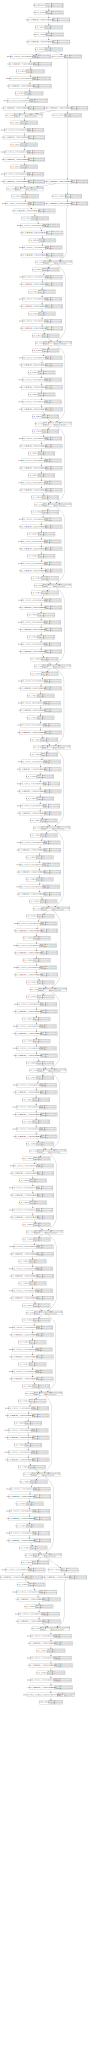

In [ ]:
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import pydot
import graphviz

SVG(model_to_dot(model, show_shapes=True, show_layer_names=True, rankdir='TB',expand_nested=False, dpi=60, subgraph=False).create(prog='dot',format='svg'))

## **Create the checkpoints to be applied during training**
---
* Step 1: Create a checkpoint to save the model from an epoch when validation accuracy is the highest
* Step 2: Create a checkpoint to save the training loss, training accuracy, validation loss and validation accuracy of each epoch into a csv file
* Step 3: Put the two checkpoint objects into a list


In [ ]:
                                                                                # Step 1
folderpath      = '/content/gdrive/My Drive/iss/capstone/colab/'
filepath        = folderpath + modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_accuracy', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

csv_logger      = CSVLogger(folderpath+modelname +'.csv')                       # Step 2
callbacks_list  = [checkpoint,csv_logger]                                       # Step 3

print("Callbacks created:")
print(callbacks_list[0])
print(callbacks_list[1])
print('')
print("Path to model:", filepath)
print("Path to log:  ", folderpath+modelname+'.csv')

Callbacks created:

Path to model: /content/gdrive/My Drive/iss/capstone/colab/Xception.hdf5
Path to log:   /content/gdrive/My Drive/iss/capstone/colab/Xception.csv


In [ ]:
#train the model

model.fit(trDat,                     # Training data
          trLbl,                            # Training label
          validation_data=(tsDat, tsLbl),   # Validation data and label
          epochs=100,                       # The amount of epochs to be trained
          batch_size=128,                   
          shuffle=True,                     # To shuffle the training data
          callbacks=callbacks_list)         # Callbacks to execute the checkpoints

Epoch 1/100


ValueError: ignored

In [ ]:
#validate the model

modelGo.load_weights(filepath)
modelGo.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                optimizer=optmz, 
                metrics=['accuracy'])

predicts    = modelGo.predict([tsDat,tsDat])                                    # Step 2
print("Prediction completes.")

In [ ]:
#Calculate the accuracy score

labelname   = ['airplane',          # The label for reporting metrics
               'automobile',
               'bird',
               'cat',
               'deer',
               'dog',
               'frog',
               'horse',
               'ship',
               'truck']
                                                                                # Step 2
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(tsLbl,axis=1)

testScores  = metrics.accuracy_score(testout,predout)                           # Step 3

                                                                                # Step 4
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,
                                    predout,
                                    target_names=labelname,
                                    digits=4))